In [68]:
import os

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
import torchvision as tv

import pytorch_lightning as pl

import matplotlib.pyplot as plt

torch.set_float32_matmul_precision('high')

In [69]:
class MnistDataLoader(pl.LightningDataModule):
    def __init__(self,root,batch_size,num_workers):
        super(MnistDataLoader,self).__init__()
        self.root = root
        self.batch_size = batch_size
        self.num_workers = num_workers
        
        
    def prepare_data(self):
        datasets.MNIST(root = self.root,train=True,download=True)
        datasets.MNIST(root = self.root,train=False,download=True)

    def setup(self, stage):
        train_dataset = datasets.MNIST(root = self.root,train=True,download=False,transform = transforms.ToTensor())
        self.test_dataset =  datasets.MNIST(root = self.root,train=False,download=False,transform = transforms.ToTensor())
        # Define the proportions for the split
        train_proportion = 0.8  # 80% for training
        val_proportion = 0.2  # 20% for validation

        # Calculate the sizes of training and validation sets based on the proportions
        train_size = int(train_proportion * len(train_dataset))
        val_size = len(train_dataset) - train_size
        
        # Use random_split to split the dataset
        self.train_dataset, self.val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])
        

    def train_dataloader(self):
        return torch.utils.data.DataLoader(dataset=self.train_dataset,batch_size=self.batch_size,shuffle=True,num_workers=self.num_workers,pin_memory=True)
    
    def val_dataloader(self):
        return torch.utils.data.DataLoader(dataset=self.val_dataset,batch_size=self.batch_size,shuffle=False,num_workers=self.num_workers,pin_memory=True)
    
    def test_dataloader(self):
        return torch.utils.data.DataLoader(dataset=self.test_dataset,batch_size=self.batch_size,shuffle=False,num_workers=self.num_workers,pin_memory=True)
   

In [70]:
root ="../data/"
batch_size = 512
num_workers = 16
ds = MnistDataLoader(root,batch_size,num_workers)

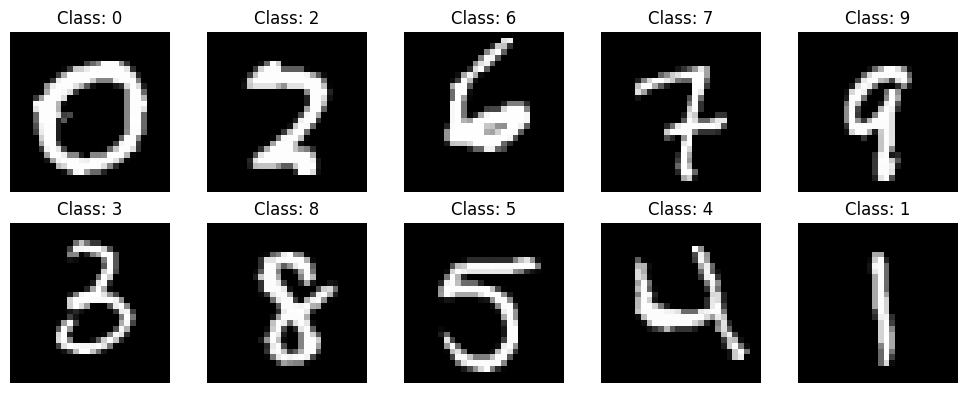

In [71]:

# Sanity Check
ds.prepare_data()
ds.setup('fit')
dataloader = ds.train_dataloader()


# Create a dictionary to store one image per class
class_images = {}

# Iterate over the dataset and store one image per class
for image, label in ds.train_dataset:
    if label not in class_images:
        class_images[label] = image
        if len(class_images) == 10:  # Stop after storing one image per class
            break

# Display the images from each class
fig, axes = plt.subplots(2, 5, figsize=(10, 4))
for i, (label, image) in enumerate(class_images.items()):
    ax = axes[i // 5, i % 5]
    ax.imshow(image.squeeze(), cmap='gray')
    ax.set_title(f"Class: {label}")
    ax.axis('off')

plt.tight_layout()
plt.show()

In [72]:
class VariationalAutoencoder(pl.LightningModule):
    
    def __init__(self,input_size,hidden_size,latent_size,output_size,lr=1e-3):
        super(VariationalAutoencoder,self).__init__()
        
        self.hidden_layer = nn.Sequential(nn.Linear(input_size,hidden_size),nn.LeakyReLU())
        self.mean = nn.Linear(hidden_size,latent_size)
        self.std = nn.Linear(hidden_size,latent_size)
        self.decoder = nn.Sequential(nn.Linear(latent_size,hidden_size),nn.LeakyReLU(),nn.Linear(hidden_size,input_size),nn.Sigmoid())
        
        self.learning_rate = lr

    def reparametrization(self,mean,std):
        mu = torch.exp(0.5 * std)  #σ=(exp(std))**0.5 =exp(0.5×std)
        eps = torch.randn_like(std)
        return mean + mu * eps
        
    def forward(self,x):
        # x /= 255 # [0,1]
        x = x.flatten(start_dim=1)

        h = self.hidden_layer(x)
        mean, std = self.mean(h),self.std(h)
        z = self.reparametrization(mean,std)
        return self.decoder(z), mean, std, x
    
    def training_step(self, batch):
        x, _ = batch
        loss = self._common_step(x)
        
        self.log('train_loss', loss, prog_bar=True, on_step=False, on_epoch=True)       
        return loss
    
    
    def validation_step(self, batch):
        x, _ = batch
        loss = self._common_step(x)
        
        self.log('val_loss', loss, prog_bar=True, on_step=False, on_epoch=True)
        
        return loss

    def test_step(self, batch):
        x, _ = batch
        loss = self._common_step(x)
        
        self.log('test_loss', loss, prog_bar=True, on_step=False, on_epoch=True)
        return loss

    def _common_step(self,x):
        
        x_hat,mu,sigma, target = self.forward(x)

        # Compute reconstruction loss
        recon_loss = nn.functional.binary_cross_entropy(x_hat, target, reduction='sum')

        # Compute KL divergence between latent distribution and prior (standard normal)
        kl_div = -0.5 * torch.sum(1 + sigma - mu.pow(2) - sigma.exp())

        loss = recon_loss + kl_div
        
        return loss
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.learning_rate)

In [81]:
imgsz =  28
input_size = imgsz *imgsz 
hidden_size = 256
latent_size = 8
output_size = imgsz *imgsz 
learning_rate = 9e-3

In [82]:
model = VariationalAutoencoder(input_size, hidden_size, latent_size, output_size, lr=learning_rate)


In [83]:
# model = torch.compile(model)
# import torch._dynamo
# torch._dynamo.config.suppress_errors = True

In [84]:
trainer = pl.Trainer(min_epochs=1,
                        max_epochs=50 ,
                        # precision='16-mixed',
                        enable_model_summary=False,
                        callbacks=[pl.callbacks.EarlyStopping('val_loss',min_delta=10,patience=10)],
                        enable_checkpointing  = True,
                        log_every_n_steps=10
                    )
trainer.fit(model,ds)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


In [88]:

model.eval()
trainer.validate(model, ds)
trainer.test(model, ds)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |                                             | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        val_loss               56404.6015625
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Testing: |                                                | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss              56414.6640625
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 56414.6640625}]

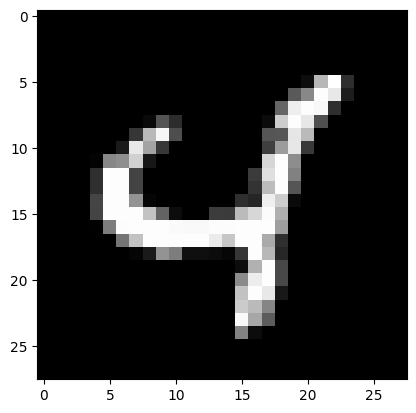

In [93]:
data_point = ds.test_dataset[67][0]
plt.imshow(data_point.permute(1,2,0),cmap='gray');

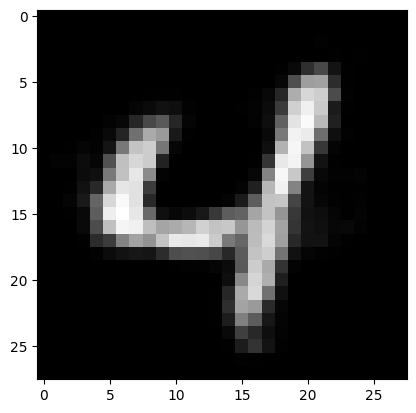

In [94]:
plt.imshow(model(data_point.view(1,1,imgsz,imgsz))[0].view(imgsz ,imgsz).detach().numpy() ,cmap='gray')